In [1]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 

using Images
using PyPlot
using JLD
using Optim

include("Common.jl")

#---------------------------------------------------------
# Load features and labels from file.
#---------------------------------------------------------
function loaddata(path::String)

  features = JLD.load(path,"features")
  labels = JLD.load(path,"labels")
  @assert length(labels) == size(features,1)
  return features::Array{Float64,2}, labels::Array{Float64,1}
end

#---------------------------------------------------------
# Show a 2-dimensional plot for the given features with
# different colors according to the labels.
#---------------------------------------------------------
function showbefore(features::Array{Float64,2},labels::Array{Float64,1})

figure()
label0 = find(labels.==0.0)
label1 = find(labels.==1.0)
scatter(features[label1,1],features[label1,2],color="red",label="label1")
scatter(features[label0,1],features[label0,2],color="blue",label="label0")
legend(bbox_to_anchor=[0.80,0.80],loc=2,borderaxespad=0)
  return nothing::Void
end


#---------------------------------------------------------
# Show a 2-dimensional plot for the given features along
# with the decision boundary.
#---------------------------------------------------------
function showafter(features::Array{Float64,2},labels::Array{Float64,1}, Ws::Vector{Any}, bs::Vector{Any})
    figure()
    N = size(features,1)
    label0 = find(labels.==0.0)
    label1 = find(labels.==1.0)
    scatter(features[label1,1],features[label1,2],color="red",label="label_1")
    scatter(features[label0,1],features[label0,2],color="blue",label="label_0")
    legend(bbox_to_anchor=[0.80,0.80],loc=2,borderaxespad=0)
    px = linspace(-3.0,3.0,900)
    py = linspace(-3.0,3.0,900)
    XX,YY = Common.meshgrid(px,py)
    z = Array{Float64,2}(size(XX))
    for i=1:900
        arr = [XX[:,i] YY[:,i]]
        _,z[:,i] = predict(arr,Ws,bs)
    end
    contour(XX, YY, z,linewidth=0.25)
  return nothing::Void
end


#---------------------------------------------------------
# Implements the sigmoid function.
#---------------------------------------------------------
function sigmoid(z)
    s = 1/(1+exp(-z))
  return s
end


#---------------------------------------------------------
# Implements the derivative of the sigmoid function.
#---------------------------------------------------------
function dsigmoid_dz(z)
    y = sigmoid(z)
    dz = y*(1-y)
  return dz
end


#---------------------------------------------------------
# Evaluates the loss function of the MLP.
#---------------------------------------------------------
function nnloss(theta::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})
    
    no_data = size(X,2)
    Y_final = Array{Float64}(no_data)
    no_layers = size(netdefinition,1)-1
    Ws,bs = thetaToWeights(theta, netdefinition)
    input = copy(X)
    for j=1:no_layers #for first layer input is features
        intermediate_output = sigmoid.((input*Ws[j]).+ bs[j]')
        input = intermediate_output
        Y_final = intermediate_output
    end
    Y_final = Y_final[:,1]
    loss = -y.*log.(Y_final) - (1-y).*log.(1-Y_final)
    loss = mean(loss)

  return loss::Float64
end


#---------------------------------------------------------
# Evaluate the gradient of the MLP loss w.r.t. Ws and Bs
# The gradient should be stored in the vector 'storage'
#---------------------------------------------------------
function nnlossgrad(theta::Array{Float64,1}, storage::Array{Float64,1}, X::Array{Float64,2}, y::Array{Float64,1}, netdefinition::Array{Int, 1})
 
    no_layers = length(netdefinition)-1
    
    #temp = zeros(0)
    temp1 = zeros(theta)
    
    Ws,bs = thetaToWeights(theta,netdefinition)
    Y_output,storage_deri = calculate_output(Ws,bs,X) 
    backprop = calculate_backprop(storage_deri,Ws)
    no_features = size(X,1) 
    #no_features=1
    for k=1:no_features ###feature k
        storage_w = []
        storage_b = []
        input = X[k,:]
        delta_loss = -y[k]/Y_output[end][k,1] +(1-y[k])/(1-Y_output[end][k,1])
        for j = 1:no_layers
           storage_temp = (delta_loss*backprop[j][k,:]*input')'
           storage_w = push!(storage_w,storage_temp) #*backprop[j]
           storage_b = push!(storage_b,delta_loss*backprop[j][k,:]) #*backprop[j]           
           input = Y_output[j][k,:]  #intermediate output->input for the next layer
        #   display(storage_w)
        end
        temp = weightsToTheta(storage_w, storage_b)
        temp = temp./no_features
        temp1 = temp1 + temp
    end
    for i=1:size(temp1,1)
    storage[i]=temp1[i]
    end
   

  return storage::Array{Float64,1}
end

function calculate_output(Ws::Vector{Any}, bs::Vector{Any},X::Array{Float64,2})
    no_data = size(X,2)
    no_layers = size(Ws,1)
    output = Array{Array{Float64,2}}(no_layers)
    o_before_sig = Array{Array{Float64,2}}(no_layers)
    storage_deri = Array{Array{Float64,2}}(no_layers)
    input = copy(X)
    for j=1:no_layers #for first layer input is features
        o_before_sig[j] = input*Ws[j].+ bs[j]'
        output[j] = sigmoid.(o_before_sig[j])
    storage_deri[j] = dsigmoid_dz.(o_before_sig[j])
        input = output[j]
    end
    return output::Array{Array{Float64,2},1},storage_deri::Array{Array{Float64,2},1}
end
    

    
function calculate_backprop(storage_deri::Array{Array{Float64,2},1}, Ws::Vector{Any})
    
    no_layers = size(Ws,1)
    backprop = Array{Array{Float64,2}}(no_layers)
# for the topmost layer derivative of sigmoid is used
    backprop[end] = storage_deri[end]
# calculate the backprop at each node so that for calculating gradient for the weight for immediate lower layer is easy
# for calculating backprop at a particular layer L
# product of derivative of sigmoid*backprop of higher layer(L+1)*weights just above(L+1) is taken

    for j = no_layers-1:-1:1
        if (j+1)<=no_layers
        backprop[j] = storage_deri[j].*(backprop[j+1]*Ws[j+1]') #store backprop for each node   
        end
    end

return backprop::Array{Array{Float64,2},1}
end
#---------------------------------------------------------
# Use LBFGS to optimize the MLP loss
#---------------------------------------------------------
function train(trainfeatures::Array{Float64,2}, trainlabels::Array{Float64,1}, netdefinition::Array{Int, 1})
    
    sigmaW = 1.0 #tried different values 1.0 works well , higher values not giving accurate results
    sigmaB = 1.0
    Ws,bs = initWeights(netdefinition, sigmaW, sigmaB)
    theta = weightsToTheta(Ws,bs)

    r = optimize(x->nnloss(x, trainfeatures, trainlabels, netdefinition),(x,stor)->nnlossgrad(x,stor, trainfeatures, trainlabels, netdefinition),theta,LBFGS(),Optim.Options(show_trace=true,iterations = 1000))
    theta = r.minimizer   
    Ws,bs = thetaToWeights(theta,netdefinition)

  return Ws::Vector{Any},bs::Vector{Any}
end


#---------------------------------------------------------
# Predict the classes of the given data points using Ws and Bs.
# p, N x 1 array of Array{Float,2}, contains the output class scores (continuous value) for each input feature.
# c, N x 1 array of Array{Float,2}, contains the output class label (either 0 or 1) for each input feature.
#---------------------------------------------------------
function predict(X::Array{Float64,2}, Ws::Vector{Any}, bs::Vector{Any})
        output,_ = calculate_output(Ws,bs,X)
        p = output[end]
        c = 1.0*(output[end].>0.5)
  return p::Array{Float64,2}, c::Array{Float64,2}
end


#---------------------------------------------------------
# A helper function which concatenates weights and biases into a variable theta
#---------------------------------------------------------
function weightsToTheta(Ws::Vector{Any}, bs::Vector{Any})
  
  theta=zeros(0)
#starting from lowest layer take weights and concatenate them with the biases and do vertcal concatenation
  for i=1:size(Ws,1)
    K = [Ws[i];bs[i]']
   
    theta = vcat(theta,K...)
  end
  
  return theta::Vector{Float64}
end


#---------------------------------------------------------
# A helper function which decomposes and reshapes weights and biases from the variable theta
#---------------------------------------------------------
function thetaToWeights(theta::Vector{Float64}, netdefinition::Array{Int,1})
  
   no_layers = length(netdefinition)-1
   Ws = []
   bs = []
    i_index = 1
    for i = 1:no_layers
        e_index = i_index+(netdefinition[i]+1)*netdefinition[i+1]-1 ##calculate end index for thie layer
        K = theta[i_index:e_index]
    #for each layer the weights are retrieved back by reshaping 
        K = reshape(K,netdefinition[i]+1,netdefinition[i+1]) 
        Ws_temp = K[1:end-1,:]
        bs_temp = K[end,:]
        push!(Ws,Ws_temp)
        push!(bs,bs_temp)
        i_index = e_index+1
    end

  return Ws::Vector{Any}, bs::Vector{Any}
end


#---------------------------------------------------------
# Initialize weights and biases from Gaussian distributions
#---------------------------------------------------------
function initWeights(netdefinition::Array{Int,1}, sigmaW::Float64, sigmaB::Float64)

    no_layers = length(netdefinition)-1
    Ws = []
    bs = []
    for i=1:no_layers
        Ws_temp = randn(netdefinition[i],netdefinition[i+1])
        bs_temp = randn(netdefinition[i+1])
        push!(Ws,Ws_temp)
        push!(bs,bs_temp)
    end
  return Ws::Vector{Any}, bs::Vector{Any}
end




initWeights (generic function with 1 method)

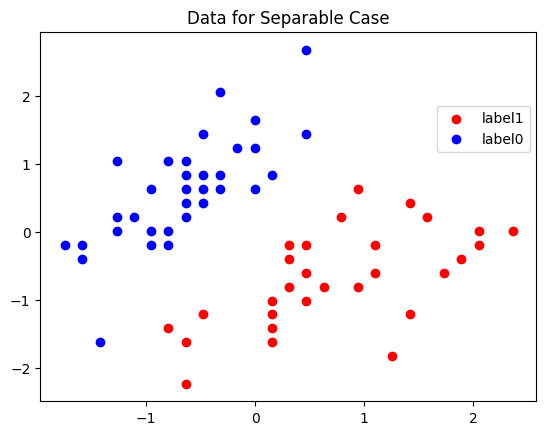

PyObject <matplotlib.text.Text object at 0x7f5f662f0b10>

In [20]:
#  Multilayer Perceptron


  # LINEAR SEPARABLE DATA
  # load data
  features,labels = loaddata("separable.jld")

  # show data points
  showbefore(features,labels)
  title("Data for Separable Case")

  

Iter     Function value   Gradient norm 
     0     9.162647e-01     2.456697e-01
     1     6.738156e-01     1.772111e-01
     1     4.708611e-01     2.218605e-01
     3     3.238715e-01     2.028242e-01
     4     1.442820e-01     6.318933e-02
     3     1.157979e-01     4.148675e-02
     6     7.839504e-03     8.743019e-03
     4     6.715349e-03     5.254807e-03
     8     4.726665e-03     3.990453e-03
     6     1.690235e-03     2.388240e-03
    10     1.500204e-03     2.813668e-03
    73     1.316212e-03     2.390373e-03
    12     1.221481e-03     1.213159e-03
    86     1.007673e-03     1.449612e-03
    14     1.700095e-04     4.088446e-04
    98     8.978236e-07     8.978178e-07
 

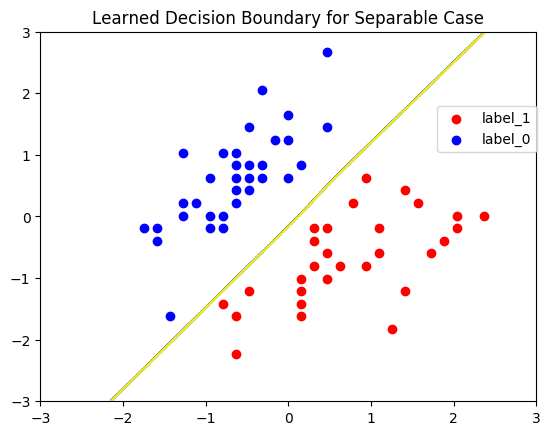

   84     4.254099e-12     2.620998e-12


PyObject <matplotlib.text.Text object at 0x7f5f8344a5d0>

In [21]:
# train MLP
  Ws,bs = train(features,labels, [2,4,1])

  # show optimum and plot decision boundary
  showafter(features,labels,Ws,bs)
  title("Learned Decision Boundary for Separable Case")


  

Iter     Function value   Gradient norm 
     0     8.714176e-01     3.487219e-01
     1     5.508373e-01     1.611545e-01
     7     4.911049e-01     1.372233e-01
     3     2.601930e-01     2.199123e-02
     9     2.044518e-01     2.127252e-02
     1     1.907843e-01     1.922859e-02
     1     1.878507e-01     1.168036e-02
     7     1.869272e-01     6.541148e-03
     2     1.865170e-01     6.580001e-03
     9     1.833583e-01     4.950498e-03
    31     1.831645e-01     5.454985e-03
    11     1.816532e-01     3.904628e-03
    44     1.813743e-01     1.176894e-03
    13     1.813567e-01     7.714255e-04
    54     1.813487e-01     9.788727e-04
    15     1.812854e-01     1.723040e-03
    64     1.806277e-01     1.122998e-03
    17     1.805896e-01     1.243319e-03
    77     1.803845e-01     1.725607e-03
    19     1.803353e-01     2.148154e-03
    88     1.803206e-01     1.521243e-03
    21     1.803058e-01     1.754355e-03
    22     1.802189e-01     2.172564e-03
    23     1.800

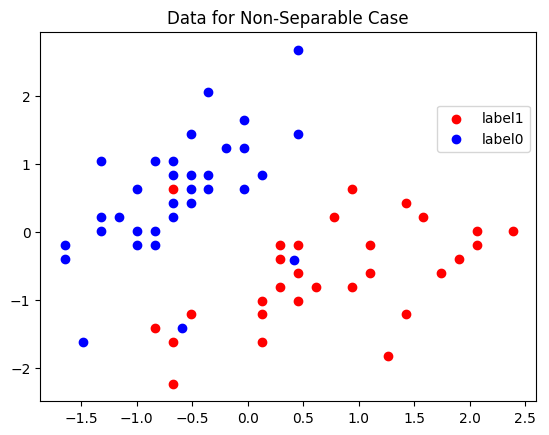

   93     1.391942e-01     2.609160e-03


(Any[
[-4.87431 -11.2376 -1.34149 28.5793; -0.18558 12.5656 23.9542 -20.6781],

[14.5524; -30.4044; 19.7473; 23.922]],Any[[-16.9678,15.5987,1.40854,4.00532],[7.37591]])

In [22]:

  # LINEAR NON-SEPARABLE DATA
  # load data
  features2,labels2 = loaddata("nonseparable.jld")

  # show data points
  showbefore(features2,labels2)
  title("Data for Non-Separable Case")

  # train MLP

  Ws,bs = train(features2,labels2, [2,4,1])

  

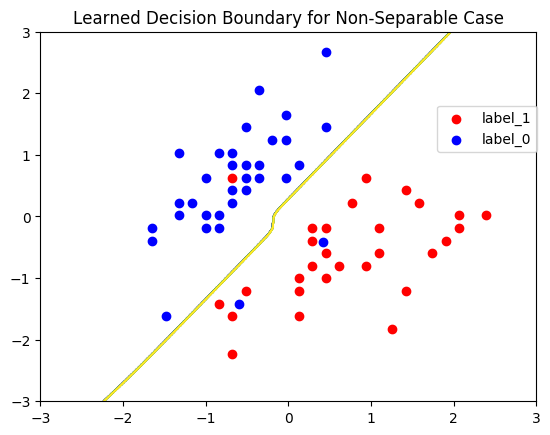

PyObject <matplotlib.text.Text object at 0x7f5f65fb2450>

In [23]:
# show optimum and plot decision boundary
  showafter(features2,labels2,Ws, bs)
  title("Learned Decision Boundary for Non-Separable Case")
  
#after a lot of trial and error found that 3 hidden layers performs well
#The error also depends on the initial weight and is not consistent as weights keep changing for each iteration  


In [24]:
# PLANE-BIKE-CLASSIFICATION 
  # load data
  trainfeatures,trainlabels = loaddata("imgstrain_gold.jld")
  testfeatures,testlabels = loaddata("imgstest_gold.jld")

  # train MLP and predict classes
     var_hidden_layer=3
     net_def = [50,6,6,6,1]
   
  Ws,bs = train(trainfeatures,trainlabels, net_def)
  _,trainpredictions = predict(trainfeatures, Ws, bs)
  _,testpredictions = predict(testfeatures, Ws, bs)

 

Iter     Function value   Gradient norm 
     0     8.248722e-01     2.522687e-01
     5     6.946320e-01     6.253572e-02
     1     6.867289e-01     4.181486e-03
     5     6.855245e-01     1.943414e-02
     2     6.808885e-01     2.844250e-02
     8     6.645894e-01     8.413471e-02
     6     6.298122e-01     1.565246e-02
     7     6.286881e-01     1.739056e-02
     9     6.198574e-01     5.617311e-02
     7     5.906728e-01     1.094602e-01
    40     5.722722e-01     3.485549e-01
    81     3.802720e-01     2.185879e-01
    34     2.267081e-01     1.916785e-01
    99     1.906126e-01     9.389973e-02
    40     1.019136e-01     2.320084e-01
    59     6.246371e-02     4.158709e-02
    62     4.188684e-02     1.263090e-01
    37     2.855896e-02     9.640724e-02
    19     1.910564e-02     9.341757e-02
    62     2.807485e-03     1.945426e-02
    56     1.062115e-03     1.018627e-01
    33     1.651445e-05     3.053191e-05
    77     1.651445e-05     3.053191e-05


(
[1.14909e-5; 1.14909e-5; … ; 1.0; 1.0],

[0.0; 0.0; … ; 1.0; 1.0])

In [25]:
 # show error
  trainerror = sum(trainpredictions.!=trainlabels)/length(trainlabels)
  testerror = sum(testpredictions.!=testlabels)/length(testlabels)
  println("Training Error Rate: $(round(100*trainerror,2))%")
  println("Testing Error Rate: $(round(100*testerror,2))%")


  

Training Error Rate: 0.0%
Testing Error Rate: 1.67%
